### Introduction

Previously we learn how to run a simulation using the Alpha-Carbon (CA) coarse grained model. Now we use a more detailed model which includes all the heavy atoms in the protein. The procedure is exactly the same, the only variation is probably that the simulations take more time to run because of the larger number of atoms and interactions.

### Requirements 

- [OpenMM python API](http://openmm.org/)
- [bmOpenMM library](https://bitbucket.org/compbiochbiophlab/sbm-openmm/src)
- [MDTraj library](http://mdtraj.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

### All-Heavy Atom SBM simulations - The All-Atom (AA) model

The AA model uses harmonic forces to maintain bonds and angles, similarly to the CA model, but additionally to keep improper and planar torsions. Impropers and planars are included because the residues are represented with all the backbone and side chain atoms and there is need to keep the local molecular geometry for specific atom hybridisations (remember also that the models do not use hydrogen atoms explicitly and chiral inversions are now possible). Proper torsions are kept by using a periodic torsion potential (same as in the CA model). Native contacts interact through a cannonical 12-6 Lennard-Jones (LJ) potential and excluded volume is enforced with a repulsive-only 12-exponent LJ.

In the sbmOpenMM.models class we can load the AA model using as input a PDB file and a contact file. The PDB file must contain the structure of the system we wish to simulate, always considering that the different chains of the proteins are continuous (i.e. not missing internal residues) and do not contain ligands or solvent molecules (just the protein atoms with or without hydrogens). The contact file contains the indexes of the atoms forming the native interactions, which are present in the native target configuration.

Let's first import OpenMM and sbmOpenMM libraries:

In [1]:
#Import OpenMM library
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

#Import sbmOpenMM library
import sbmOpenMM

The PDB and contact file are provided in the input folder of this tutorial.

In [2]:
#Set the input locations as variables.
pdb_file = 'inputs/1YPA_I.pdb'
contact_file = 'inputs/1YPA_I_AA.contacts'

We load these two files using the method sbmOpenMM.models.getAllAtomModel() to generate all we need to simulate the system using the AA model:

In [3]:
#Create an sbmOpenMM system object and store it in "sbmAAModelModel" 
sbmAAModel = sbmOpenMM.models.getAllAtomModel(pdb_file, contact_file)

Generating AA SBM for PDB file inputs/1YPA_I.pdb

Setting up geometrical parameters:
_________________________________
Removing hydrogens from topology
Added 504 atoms
Added 511 bonds
Added 693 angles
Added 606 torsions
Added 118 impropers
Added 210 planars
Reading contacts from contact file: inputs/1YPA_I_AA.contacts
Added 592 native contacts

Setting up default forcefield parameters:
________________________________________
Adding default bond parameters:
Adding default angle parameters:
grouping torsions in backbone and side-chain groups:
Adding default torsion parameters:
Adding default improper parameters:
Adding default planar parameters:
Adding default contact parameters:

Adding Forces:
_____________
Adding Harmonic Bond Forces
Adding Harmonic Angle Forces
Adding Periodic Torsion Forces
Adding Harmonic Improper Forces
Adding Periodic Planar Forces
Adding Lennard Jones 12-6 Forces to native contacts
Adding Lennard Jones 12 non-bonded Forces

Creating System Object:
_____________

The method first gathers all geometrical values for bonds, angles, torsions, impropers and planars. Then, it reads the contact file to add the native contact information. To set up the default forcefield parameters it must follow certain rules, specially, for assigning energies to each torsion and native contacts. In the default implementation the torsions are grouped by middle bonds and into backbone and sidechain torsions. The energies are then assigned based on a energy partition scheme that mantains a specific ratio between the total native contact energy and the total torsional energy (for more details see.). After assigning the forcefield paramaters the force object are created and added to the OpenMM system object, analogously to the creation of the CA model. 

Now we follow the OpenMM procedure to simulate our system for 1 ns. Notice that the timestep has increased now to 2 fs. 

In [4]:
import time

In [5]:
#Define integrator and context for the simulation
integrator = LangevinIntegrator(100, 1/picosecond, 2*femtoseconds)
simulation = Simulation(sbmAAModel.topology, sbmAAModel.system, integrator)

#Set initial positions
simulation.context.setPositions(sbmAAModel.positions)

#Add a DCD reporter that writes coordinates every 100 steps.
simulation.reporters.append(DCDReporter('traj.dcd', 100))

#Add a SBM reporter that writes energies every 100 steps.
simulation.reporters.append(sbmOpenMM.sbmReporter('energy.data', 100, sbmObject=sbmAAModel,
                                                  step=True, potentialEnergy=True, temperature=True))

print('Simulation started')
start_time = time.time()
for i in range(5000):
    simulation.step(100)
print("--- Finished in %s seconds ---" % ((time.time() - start_time)))

Simulation started
--- Finished in 47.589680194854736 seconds ---


The simulation took 47 seconds to complete using a laptop computer with a GeForce GTX 1050 Mobile GPU. Notice that this is shorter than the alpha-carbon simulation (which took approximately a minute), because of a wider use of the GPU's processors (more atoms than the CA model means that it got closer to using the whole GPU's capacity) and the larger timestep (2.0 fs vs 0.5 fs). 

We can now plot the energy progress of the simulation. For this we import matplotlib and numpy.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
energy_file = 'energy.data'

Average : 413.0045 kj/mol
Standard deviation : 31.8649 kj/mol


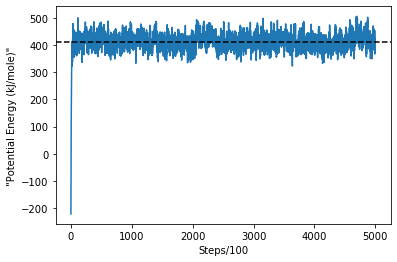

In [16]:
#Create a list to store the energy values
potentialEnergy = []
#Read the energy files and save the lines into a variable
with open(energy_file) as ef:
    lines = ef.readlines()
    #Read the header from the second comma separated value of the first line
    header = lines[0].split(',')[1]
    #Iterate over all but the first line to extract the potential energy values
    for line in lines[1:]:
        potentialEnergy.append(float(line.split(',')[1]))
        
#Plot the potential energy
plt.plot(potentialEnergy)
plt.xlabel('Steps/100')
plt.ylabel(header)
plt.axhline(np.average(potentialEnergy), c='k', ls='--')
print('Average : %.4f kj/mol' % np.average(potentialEnergy))
print('Standard deviation : %.4f kj/mol' % np.std(potentialEnergy))

The system's energy gets stable at the begining of the simulation and remains like that for the remaining of the simulation time. We plot now the system's RMSD regarding the input structure:

In [18]:
import mdtraj as md

Average : 2.1821 kj/mol
Standard deviation : 0.3205 kj/mol


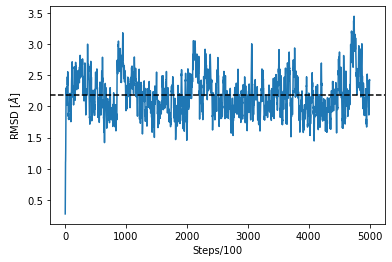

In [20]:
#We dump the current system pdb
sbmAAModel.dumpPdb('input.pdb')

#Load input.pdb as the reference structure
reference = md.load('input.pdb')

#Load input.pdb as the toplogy and traj.dcd as the trajectory file
trajectory = md.load('traj.dcd', top='input.pdb')

#Calculate the rmsd
rmsd = md.rmsd(trajectory, reference)*10 #Convert from nm to angstroms

#Plot the RMSD
plt.plot(rmsd)
plt.xlabel('Steps/100')
plt.ylabel('RMSD [$\AA$]')
plt.axhline(np.average(rmsd), c='k', ls='--')
print('Average : %.4f kj/mol' % np.average(rmsd))
print('Standard deviation : %.4f kj/mol' % np.std(rmsd))

The simulation oscillates at 2.2 angstroms RMSD of the input structure with a very small standard deviation.

### Summary

We have used sbmOpenMM library to generate a simulation with the default SBM All-Atom model. The library takes two inputs to set up the SBM system, a pdb file and a contact file created externally. Only one line is necessary to create the forcefield and system information, everything else is mainly the standard simulation routine with OpenMM. A special reporter class exists inside sbmOpenMM which facilitates the printing of the forcefield energies into an output file. Analysis of the simulation data is usually made post production and can be facilitated by using external python libraries. 